In [4]:
# Audio preprocessing
import librosa
import soundfile as sf
import numpy as np
from pydub import AudioSegment
import seaborn as sns

/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [1]:
def load_audio(file_path, target_sr=16000):
    """
    Load a WAV audio file and resample it to a fixed sampling rate.
    
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sampling rate (default: 16kHz).
    
    Returns:
        y (numpy array): Audio waveform.
        sr (int): Sampling rate of the loaded audio.
    """
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

In [2]:
def rms_normalization(audio, target_rms=0.1):
    """
    Normalize the audio signal to a fixed RMS (Root Mean Square) value.

    Args:
        audio (numpy array): Input audio waveform.
        target_rms (float): Target RMS level.

    Returns:
        y_norm (numpy array): RMS-normalized audio waveform.
    """
    rms = np.sqrt(np.mean(audio**2))  # Compute current RMS
    scaling_factor = target_rms / (rms + 1e-10)  # Avoid division by zero
    y_norm = audio * scaling_factor  # Scale audio to match target RMS

    return y_norm

In [95]:
import librosa
import numpy as np

def calculate_features(audio_path):
    y, sr = load_audio(audio_path)  # Load and resample
    y_norm = rms_normalization(y)  # Normalize volume
    features = {}

    # --- 1. MFCCs ---
    mfccs = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    features['mfccs'] = mfccs_mean

    # --- 1b. Delta MFCCs ---
    mfccs_delta = librosa.feature.delta(mfccs)
    delta_mean = np.mean(mfccs_delta, axis=1)
    features['delta_mfccs'] = delta_mean

    # --- 2. Spectral Entropy ---
    spec = np.abs(librosa.stft(y_norm, n_fft=2048))
    col_sums = np.sum(spec, axis=0, keepdims=True)
    col_sums[col_sums == 0] = 1e-10
    prob_dist = spec / col_sums
    entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10), axis=0)
    features['spectral_entropy'] = np.mean(entropy)

    # --- 3. Zero-Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y_norm)
    features['zcr'] = np.mean(zcr)

    # --- 4. Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y_norm, sr=sr)
    features['spectral_centroid'] = np.mean(centroid)

    # --- 5. Spectral Bandwidth ---
    bandwidth = librosa.feature.spectral_bandwidth(y=y_norm, sr=sr)
    features['spectral_bandwidth'] = np.mean(bandwidth)

    # --- 6. Chroma STFT ---
    chroma = librosa.feature.chroma_stft(y=y_norm, sr=sr)
    features['chroma_stft'] = np.mean(chroma, axis=1)

    # --- 7. Spectral Roll-off ---
    rolloff = librosa.feature.spectral_rolloff(y=y_norm, sr=sr)
    features['rolloff'] = np.mean(rolloff)

    # Combine all features into a single vector
    feature_vector = np.concatenate([
        features['mfccs'],
        features['delta_mfccs'],
        [features['spectral_entropy']],
        [features['zcr']],
        [features['spectral_centroid']],
        [features['spectral_bandwidth']],
        features['chroma_stft'],
        [features['rolloff']]
    ])

    return feature_vector

In [96]:
audios = [
    'output_audios/audio1.wav',
    # 'output_audios/audio2.wav',
    # 'output_audios/audio3.wav',
    'output_audios/audio4.wav',
    # 'output_audios/audio6.wav',
    # 'output_audios/audio7.wav',
    # 'output_audios/audio8.wav',
    # 'output_audios/audio9.wav',
    # 'output_audios/audio10.wav',
    # 'output_audios/audio11.wav',
    # 'output_audios/audio12.wav',
    # 'output_audios/audio13.wav',
    # 'output_audios/audio14.wav',
    # 'output_audios/audio15.wav',
    # 'output_audios/audio16.wav',
    # 'output_audios/audio17.wav',
    # 'output_audios/9 Apr, 3.21 pm.wav',
    # 'output_audios/New recording 21.wav',
]
X = [calculate_features(audio) for audio in audios]

In [104]:
print(X)

[array([-1.15282898e+02,  1.33760696e+02, -2.47462921e+01,  4.56455803e+01,
       -2.85112019e+01,  1.40439081e+01, -1.89290295e+01,  2.23694038e+01,
       -1.23675194e+01,  7.94238997e+00, -1.11199665e+01,  5.90307570e+00,
       -3.29176235e+00, -2.00144351e-01, -9.32979584e-03,  6.72675669e-02,
        1.09358607e-02,  4.03179564e-02,  4.34856378e-02,  1.29921492e-02,
        2.24368069e-02, -3.12747061e-02,  5.65124229e-02, -1.09147495e-02,
       -3.64247710e-02, -2.41834894e-02,  8.24116039e+00,  1.03917321e-01,
        1.32087362e+03,  1.37870095e+03,  3.88639271e-01,  3.85591328e-01,
        3.36193591e-01,  3.88681382e-01,  3.43303353e-01,  3.20649683e-01,
        3.12035531e-01,  3.82886887e-01,  4.62398410e-01,  5.15702486e-01,
        4.79366183e-01,  3.94836634e-01,  2.76925872e+03]), array([-6.04351997e+01,  7.60707855e+01, -1.28124743e+01,  2.80635624e+01,
       -6.79803014e-01,  1.96309929e+01,  8.18261433e+00,  5.49435425e+00,
        2.70960498e+00,  1.09992361e+01

In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your feature matrix


In [108]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


similarity = cosine_similarity([X[0]], [X[1]])[0][0]
print("Cosine similarity:", similarity)

similarity = cosine_similarity([X_scaled[0]], [X_scaled[1]])[0][0]
print("Cosine similarity (after scaling):", similarity)


Cosine similarity: 0.9989197324038975
Cosine similarity (after scaling): -1.0000000000000004


In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics.pairwise import cosine_distances
# from sklearn.cluster import DBSCAN

# distance_matrix = cosine_distances(X)
# model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, metric='precomputed', linkage='average')
# labels = model.fit_predict(distance_matrix)
# labels

# # Run DBSCAN with precomputed cosine distances
# dbscan = DBSCAN(eps=0.001, min_samples=2, metric='precomputed')
# labels = dbscan.fit_predict(distance_matrix)

# print("Cluster Labels:", labels)

Cluster Labels: [-1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0]


In [15]:
# Step 4 - Clustering
from sklearn.preprocessing import StandardScaler
import hdbscan

In [21]:
# --- Step 1: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.70710678, -0.70710678, -0.70710678, -0.70710678,  0.70710678,
         0.70710678,  0.70710678, -0.70710678,  0.70710678,  0.70710678,
        -0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
         0.70710678,  0.70710678],
       [-1.41421356,  1.41421356,  1.41421356,  1.41421356, -1.41421356,
        -1.41421356, -1.41421356,  1.41421356, -1.41421356, -1.41421356,
         1.41421356, -1.41421356, -1.41421356, -1.41421356, -1.41421356,
        -1.41421356, -1.41421356],
       [-1.41421356,  1.41421356,  1.41421356,  1.41421356, -1.41421356,
        -1.41421356, -1.41421356,  1.41421356, -1.41421356, -1.41421356,
         1.41421356, -1.41421356, -1.41421356, -1.41421356, -1.41421356,
        -1.41421356, -1.41421356],
       [-1.41421356,  1.41421356,  1.41421356,  1.41421356, -1.41421356,
        -1.41421356, -1.41421356,  1.41421356, -1.41421356, -1.41421356,
         1.41421356, -1.41421356, -1.41421356, -1.41421356, -1.41421356,
        -1.41421356

[[ 2.91547595e+00 -7.60696417e-16]
 [-5.83095189e+00 -2.63339650e-16]
 [-5.83095189e+00 -2.63339650e-16]
 [-5.83095189e+00 -2.63339650e-16]
 [ 2.91547595e+00  1.87780323e-16]
 [ 2.91547595e+00  1.87780323e-16]
 [ 2.91547595e+00  1.87780323e-16]
 [ 2.91547595e+00  1.87780323e-16]
 [ 2.91547595e+00  1.87780323e-16]
 [ 2.91547595e+00 -2.55633517e-16]
 [-5.83095189e+00  6.23488030e-16]
 [ 2.91547595e+00 -2.55633517e-16]]


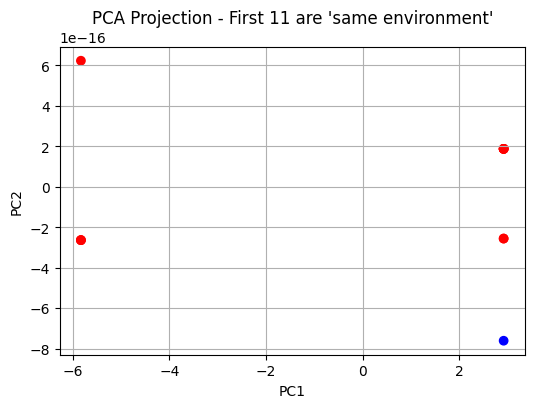

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
X_2d = pca.fit_transform(X_scaled)
# print(X_2d)

# # Visualize: color first 11 as one group
# colors = ['blue']*4 + ['red']*11

# plt.figure(figsize=(6,4))
# plt.scatter(X_2d[:,0], X_2d[:,1], c=colors)
# plt.title("PCA Projection - First 11 are 'same environment'")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.grid(True)
# plt.show()

In [ ]:
# --- Step 2: Cluster using HDBSCAN ---
from sklearn.decomposition import PCA
# Reduce dimensions first

# Now cluster on the PCA-reduced data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1,prediction_data=True)
labels = clusterer.fit_predict(X_2d)
labels

/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [268]:
# plt.figure(figsize=(6, 4))
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=60)
# plt.title("HDBSCAN Clustering on PCA Projection")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.grid(True)
# plt.show()

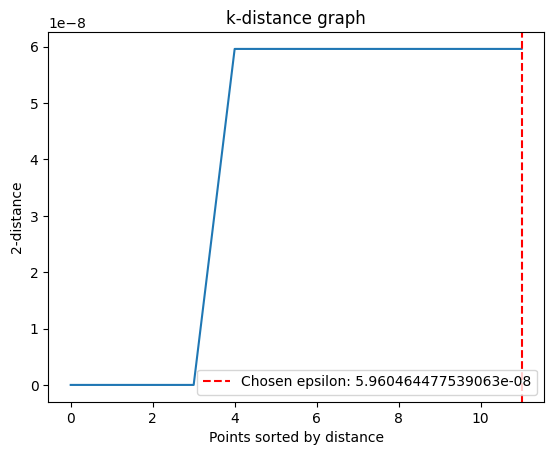

Chosen epsilon value: 5.960464477539063e-08


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

# Step 1: Calculate k-distances
k = 5  # min_samples value
nbrs = NearestNeighbors(n_neighbors=k).fit(X_2d)
distances, indices = nbrs.kneighbors(X_2d)

# Sort the distances in ascending order
distances = np.sort(distances[:, -1], axis=0)

# Step 2: Use KneeLocator to find the optimal epsilon (elbow)
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
epsilon = distances[kneedle.elbow]


# Step 3: Plot the k-distance graph and highlight the chosen epsilon
plt.plot(distances)
plt.axvline(x=kneedle.elbow, color='r', linestyle='--', label=f'Chosen epsilon: {epsilon}')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-distance')
plt.title('k-distance graph')
plt.legend()
plt.show()

# Step 4: Use the optimal epsilon for DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=k)
labels = dbscan.fit_predict(X_2d)

print(f"Chosen epsilon value: {epsilon}")

In [ ]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=epsilon, min_samples=5)
labels = clusterer.fit_predict(X_2d)
labels

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])